# Introduction to Different Peak Fitting in Python

So far you have been introduced to the python programming language, working with arrays, importing data simple curve fitting, and doing simple peak fittings. In this tutorial we are going to apply those skills to different peak fitting data to improve accuracy of fitting and uncertainty value.

After this tutorial you should be able to:

    Fit data with multiple Gaussian distributions
    Fit data with Lorentzian Function
    Combine Gaussian and Lorentzian into pseudo Voigt analysis
    Deduce each methods uncertainty
Using Gaussian and Lorentzian distributions to fit the dataset is reasonable for data with little noise undergoing multiple separate component distributions.

We'll be using the same imports as our previous tutorials with new important additions, math from which we import pi,sin. 

In [1]:

import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
from scipy.optimize import curve_fit
from math import pi,sin

# Importing the Data
For this tutorial I already have a datafile of xrd data. This datafile is stacked .csv where the first column is the value of 2-theta and subsequent columns are diffracted intensity for a variety of samples.
To import the data we're going to define a function "csv_to_np" which will use the read_csv function built into pandas to pull the data, and then convert it to a numpy array since we're already familiar with working with those.

First, given that It's worthwhile to make a function that will convert our data with respect to Q go ahead and use the two_to_q function built to pull the data, and takes in an array of 2-theta values and a X-ray wavelength 𝜆, and returns an array of Q values. Well also go ahead and define our past functions from the last tutorial since theyll be useful as well.

In [12]:
def csv_to_np(filename):
    data = pd.read_csv(filename)
    return(np.array(data))

perov = csv_to_np('D1_MAPBIBr2_Xraydeg.csv')

In [11]:
def two_to_q(two_theta, wave):
    #two_theta is a 1D array of two_theta angles
    #wave is the X-ray energy in angstroms
    rad_theta = two_theta/2*np.pi/180
    q = 4*np.pi*np.sin(rad_theta)/wave
    return q


In [13]:
def find_nearest(array, target):
    array = np.asarray(array) # In case the input is not an array type
    idx = (np.abs(array - target)).argmin() # Finds the index of the value closest to the target
    return idx

In [14]:
def gaussian(x, a, b, c): 
    return a*np.exp(-(x - b)**2/(2*c**2))

Go ahead and plot our data. Remember to plot the first column (index 0) of our 2D array (our 2-theta values) against the X-ray diffraction intensities (the values in any other column).

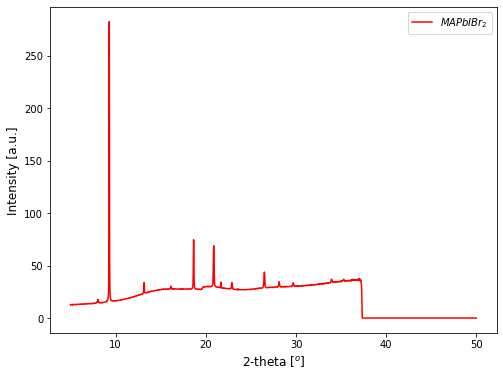

In [6]:
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(perov[:,0],perov[:,1],'r-', label='$MAPbIBr_2$') #plot two-theta versus XRD intesntiy
plt.xlabel('2-theta [$^o$]',size=12) #Define x-axis label
plt.ylabel('Intensity [a.u.]',size=12)#Define y-axis label
plt.legend(loc="upper right")#Put legend in upper left hand corner

# Trimming Data
Lets go ahead an trim out data with set limits,so we can then reference those when calling some segment of our array.


In [17]:
#We'll use our find_nearest function to find the index of real value closest to our desired limit
q=two_to_q(perov[:,0],0.9763)

#Q=q.tolist()
#FEEDBACK find nearest will return the index, you don't need to additionally call it. Additionally it does the calculation on an array, is there a reason to turn it into a list?
#print(Q)

q_1 = 0.98 # This will be the lower limit for Q we'll consider
q_2 = 1.15 # This will be our upper limit - ideally there is only one peak between these values

#limit1 = Q.index(find_nearest(q, q_1))
#limit2 =Q.index(find_nearest(q, q_2))

limit1 = find_nearest(q, q_1)
limit2 = find_nearest(q, q_2)


In [18]:
# Having extablished our limits we can now trim the data

q_sub = q[limit1:limit2] # We'll reduce the domain of Q
perov_sub = perov[limit1:limit2,1:-1] # And correspondingly shrink the size of our diffraction data set. 

# You'll also notice I'm dropping the first column of data in the perov array, since that's now accounted for in q_sub

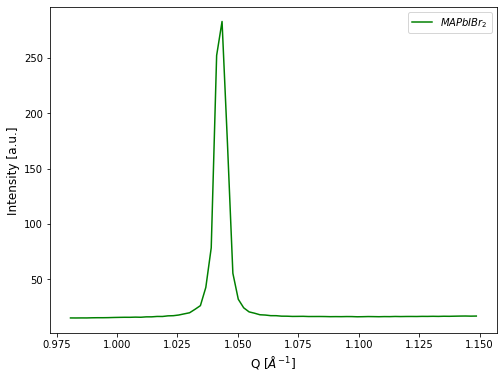

In [19]:
#Now let's go ahead and plot again to see if our trimming worked
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(q_sub,perov_sub[:,0],'g-', label='$MAPbIBr_2$') #plot subfield of data
plt.xlabel('Q [$\AA^{-1}$]',size=12) #Define x-axis label
plt.ylabel('Intensity [a.u.]',size=12)#Define y-axis label
plt.legend(loc="upper right")#Put legend in upper left hand corner

# Substracting Background
Improving the linear fitting introduced in Tutorial 04, let's fit a striaght line for the data around our peak using the size of the data files to get a non-zero baseline.

(76, 29)


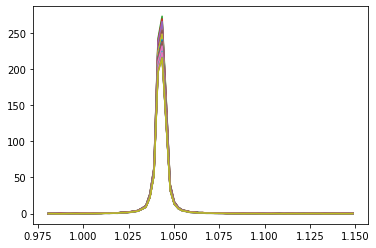

In [22]:
# Using the linear fitting introduced in Tutorial 03, let's fit a straight line for the data around our peak.
size = perov_sub.shape
print (size)
q_bins = size[0]
num_frames = size[1]
slope = np.zeros((num_frames,1))
intercept = np.zeros((num_frames,1))
back = np.zeros((q_bins,num_frames))
int_correct = np.zeros((q_bins,num_frames))

#accept a data file and range and returns average values at start and end of range
for j in range(num_frames): 
    slope[j] = ((np.mean(perov_sub[-10:-1,j])-np.mean(perov_sub[0:10,j]))/(np.mean(q[limit2-10:limit2])-np.mean(q[limit1:limit1+10])))
    intercept[j]=perov_sub[0,j]-slope[j]*q_sub[0]
    back[:,j] = [slope[j]*element+intercept[j] for element in q_sub]
    int_correct[:,j] = perov_sub[:,j]-np.array(back[:,j])

plt.plot(np.array(q_sub),int_correct)
#FEEDBACK since the focus of this tutorial is curve fitting perhaps you want to expedite that process? Compressing the improting,trimming,substracting background processes

# Guassian fitting
Like in tutorial 4, you learned how to fit the experimental data to a gaussian fit. 

Rememebr that our idelaized model is a guassian peak, which is described by the following expression:

$$f(x)=ae^{\frac{-(x-b)^2}{2c^2}}$$

Where $a$ is the height of the peak, $b$ is the peak's center, and $c$ is the standard deviation which impacts the width of the peak.


[6.02442373 6.02448715 6.02443746 6.02443651 6.02450386 6.02457133
 6.02462093 6.024679   6.02457378 6.02466153 6.02463978 6.02474891
 6.02467186 6.02469051 6.024676   6.0246775  6.02471163 6.02477428
 6.02477956 6.02473801 6.02481088 6.02475284 6.02477551 6.02480733
 6.02476764 6.02469529 6.02468502 6.02474362 6.02472499]
[2.28697226e+02 1.04289994e+00 2.51272049e-03]


Text(0, 0.5, 'Intensity')

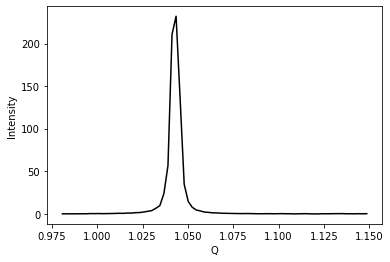

In [23]:
#We'll also give an initial guess for our fits based off of a visual interpretaion of our data depiciting a,b,c 
p0 = [250, 1, 0.2]
#FEEDBACK it would be great if we could automate this initial guess based off of the data we have. Do you have thoughts on how we could do that?

intensity_1 = np.zeros((num_frames)) #create correct size arrays for running in the loop
intensity_2= np.zeros((num_frames))
lattice_1= np.zeros((num_frames))
lattice_2 = np.zeros((num_frames))

for j in range(num_frames):
    popt, pcov = curve_fit(gaussian, np.array(q_sub), int_correct[:,j], p0)
    intensity_1[j] = popt[0]
    lattice_1[j] = 2*math.pi/popt[1] 
    p0 = popt #once you have the initial fit use that as your next guess, we expect things to be continuous so this helps with that
print (lattice_1)#lattice of all frames in sample


#%%
intensity_1 = np.zeros((num_frames))
intensity_2= np.zeros((num_frames))
intensity_3= np.zeros((num_frames))
lattice_1= np.zeros((num_frames))
lattice_2 = np.zeros((num_frames))
lattice_3 = np.zeros((num_frames))
# %%


#guassian fits with plotting
#pick fitting and initial guess
i = 2#number of fits #FEEDBACK what do you mean by number of fits?
j = 16#number of frames 
p0 = [250, 1, 0.2]
plt.plot(np.array(q_sub), int_correct[:,j],color='black')

if i==1:#if you only want one fit
    popt, pcov = curve_fit(gaussian, np.array(q_sub), int_correct[:,j], p0[0:3]) #Return co-effs for fit and covariance
    plt.plot(np.array(q_sub), gaussian(np.array(q_sub),*popt))#fitted curve
    plt.plot(np.array(q_sub), int_correct[:,j],color='black')# original curve
    print('lattice spacing:', [4*math.pi/popt[1]])
    intensity_1[j] = popt[0]
    lattice_1[j] = 2*math.pi/popt[1] 

print(popt)
plt.xlabel('Q')
plt.ylabel('Intensity')

# Lorentzian Function
Now that youve seen how much more qualitavely accurate multi guassian peak fitting is well go thorugh another idelaized model, Lorentizian peak:
                            
                          f(x;A,μ,σ)=Aπ[σ(x−μ)2+σ2]
 Like Guassian, $a$ is the height of the peak, $b$ is the peak's center, and $c$ is the standard deviation which impacts the width of the peak. In addition, parameters $fwhm$ and height are included as constraints to report full width at half maximum and maximum peak height, respectively.

In [25]:
#Now let's define a function we'll want to fit  
#We'll call our function lorentzian and it will calculate the expression described above
def lorentzian(x, a, b, c):
    return (a*b**2/((x-c)**2+b**2))



# Well be using same intensity and lattice from the orginal curve to analyze
#p0 = [x,250, 1, 0.2] #FEEDBACK when doing an intitial guess, you only need to guess a,b,c - the x will be the values for q
p0 = [*popt]

intensity_1 = np.zeros((num_frames)) #create correct size arrays for running in the loop
intensity_2= np.zeros((num_frames))
lattice_1= np.zeros((num_frames))
lattice_2 = np.zeros((num_frames))

for j in range(num_frames):
    popt, pcov = curve_fit(lorentzian, np.array(q_sub), int_correct[:,j], p0)
    intensity_1[j] = popt[0]
    lattice_1[j] = 2*math.pi/popt[1] 
    p0 = popt #once you have the initial fit use that as your next guess, we expect things to be continuous so this helps with that
print (lattice_1)#lattice of all frames in sample


#%%
intensity_1 = np.zeros((num_frames))
lattice_1= np.zeros((num_frames))
# %%




[-5.73389295e+04  5.77693140e+00  5.35857300e+00  4.94531642e+00
  4.46922934e+00  4.04599060e+00  3.68281873e+00  3.31939851e+00
  3.06226721e+00  2.85199445e+00  2.37838560e+00  2.15269544e+00
  1.95915387e+00  1.72139838e+00  1.48202975e+00  1.42877365e+00
  1.28104109e+00  1.11143027e+00  1.02517895e+00  1.01753558e+00
  9.16722163e-01  9.34702063e-01  7.10089361e-01  6.66543564e-01
  6.66434442e-01  7.23217291e-01  6.97203874e-01  6.55827277e-01
  6.95203107e-01]


# Exercise 1
You'll notice how Lorentzian fit are similar to Guassina just an added parameter, modify the code used for the Gaussian fit accordingly and plot your graph.

In [ ]:
#FEEDBACK I like this as an exercise! I wonder if you could dial it back ever further and give the lorentzian function and ask folks to write code to do the fitting and plotting. 

   # PseudoVoigt Fitting
    
   Most likely youll find data that is hard to analyze with just one gaussian or lorentzian fit indicating the material undergoing changes.

   Pseudo Voigt function is a weighted sum of a Gaussian and Lorentzian distribution functions with that share values for amplitude (A), center (μ), and full width at half maximum σ (meaning there is a contrained values of sigma).A fourth parameter fraction (α) controls the relative weight of the Gaussian and Lorentzian components:
   
                           f(x;A,μ,σ,α)=(1−α)Aσg2π‾‾‾√e[−(x−μ)2/2σg2]+αAπ[σ(x−μ)2+σ2]

Below you'll learn how much better using both fits:

We'll again use scipy.optimize.curve_fit to pull these parameters from our data set.

In [30]:
#Now let's define a function we'll want to fit to 
#We'll call our function voigt and it will calculate the expression described above
def Voigt(x, a1, b1, c1, a2, b2, c2): #FEEDBACK since the peak should have a single center, intensity, etc. a1=a2, b1=b2, c1=c2 so you only need 4 not 7 fitting parameters. You do need a relative waiting parameter thought (one that says what fraction is gaussian vs. lorentzian)
#a1,b1,c1 are all guassian parameters while a2,b2,c2 are Lorentzian
    return (a1*(1/(c1*(np.sqrt(2*np.pi))))*(np.exp(-((x-b1)**2)/((2*c1)**2)))) +\
              ((a2*c2**2/((x-b2)**2+c2**2)) )

p0 = [0.5,250, 1, 0.2]
#last parameter is input on how much of the fit is Lorentzian and/or Gaussian 0=guassian,1=Lorentzian,0.5 is a mix
intensity_1 = np.zeros((num_frames)) #create correct size arrays for running in the loop
intensity_2= np.zeros((num_frames))
lattice_1= np.zeros((num_frames))
lattice_2 = np.zeros((num_frames))

for j in range(num_frames):
    popt, pcov = curve_fit(lorentzian, np.array(q_sub), int_correct[:,j], p0)
    intensity_1[j] = popt[0]
    lattice_1[j] = 2*math.pi/popt[1] 
    p0 = popt #once you have the initial fit use that as your next guess, we expect things to be continuous so this helps with that
print (lattice_1)#lattice of all frames in sample

IndentationError: unexpected indent (<ipython-input-30-41e26ee57ecd>, line 6)

In [27]:
#We'll also give an initial guess for our fits based off of a visual interpretaion of our data but add our fourth parameter 
p0 = [0.5,250, 1, 0.2,250, 1, 0.2]


#Use scipy.optimize.curve_fit to fit our desired data
popt, pcov = curve_fit(Voigt, np.array(q_sub), perov_fit, p0)

#%%
intensity_1 = np.zeros((num_frames))
lattice_1= np.zeros((num_frames))
# %%


#guassian fits with plotting
#pick fitting and initial guess
i = 1#number of fits 
j = 16#number of frames 
p0 = [0.5,250, 1, 0.2]
plt.plot(np.array(q_sub), int_correct[:,j],color='black')

if i==1:#if you only want one fit
    popt, pcov = curve_fit(voigt, np.array(q_sub), int_correct[:,j], p0[0:7])
    plt.plot(np.array(q_sub), voigt(np.array(q_sub),*popt))#fitted curve
    plt.plot(np.array(q_sub), int_correct[:,j],color='black')# original curve
    print('lattice spacing:', [2*math.pi/popt[1]])
    intensity_1[j] = popt[0]
    lattice_1[j] = 2*math.pi/popt[1] 

print(popt)
plt.xlabel('Q')
plt.ylabel('Intensity')



NameError: name 'perov_fit' is not defined

# Exercise 2
Instead of fitting to the (100) peak, we'll often look at the (200) peak for better resolution. Create a new piece of code that succesfully finds the lattice parameter using the (200) peak instead. Do you have a more accurate prediction using the (200) peak? Remember, you will have to update your data limits for this to run succesfully.

You'll notice your lattice is of by a factor of 2, why do you think that happened? Youll have to change that piece to get the correct lattice.

# Introduction of uncertainty and quantifying for curve fitting
Looking back at how good of a fit our different models curve to the data, we are interested in analysing the quality of the fit. CurveFit returns a useful pcov matrix, from which the standard deviation of each fitting parameter can be computed as follwed:

In [32]:
# Function to calculate the power-law well use to calculate residuals with constants a and b
def power_law(x, a, b): #commonly use model: y= ax^b #FEEDBACK this is more of a question - do we need to use this to calculate the uncertainty? If we want to calculate the residuals we should just subtract our fit (so the guassian curve) from the raw data
    return a*np.power(x, b)

p0 = [250, 1, 0.2] #Initial guess of parameters for Gaussian fit 
popt, pcov = curve_fit(gaussian, np.array(q_sub), int_correct[:,j], p0[0:3]) #Return co-effs for fit and covariance

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(pcov))#‘Parameter A is %f (%f uncertainty)% (popt[0], np.sqrt(pcov[0, 0])) #FEEDBACK for our work, we're most interested in the uncertainty of our lattice spacing, so perhaps you want to emphasize that?

# Calculate the residuals
#res = gaussian(np.array(q_sub) - power_law( int_correct[:,j]), *popt)  

print(stdevs)
print(popt)

[3.58447967e+00 3.69151975e-05 3.69102409e-05]
[2.81538630e+02 1.04295209e+00 2.51084027e-03]


# Exercise 3
Use the skills youve learned so far on uncertainty to deduce wheter Pseudo-Voigt is a better curve fitting model by comparing it to Gaussian fit:

In [ ]:
#FEEDBACK really excited about these exercises!!

# Exercise 4
Now compare Pseudo-Voigt to the Lorentzian fit: